In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

import PIL
import time

from tensorflow.keras import layers

from IPython import display

In [2]:
tf.__version__
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [3]:
tf.executing_eagerly()

True

## Model

In [4]:
class ReflectionPad1d(layers.Layer):
    """Tensorflow ReflectionPad1d module."""

    def __init__(self, padding_size, padding_type="REFLECT", **kwargs):
        """Initialize TFReflectionPad1d module.
        Args:
            padding_size (int)
            padding_type (str) ("CONSTANT", "REFLECT", or "SYMMETRIC". Default is "REFLECT")
        """
        super().__init__(**kwargs)
        self.padding_size = padding_size
        self.padding_type = padding_type

    def call(self, x):
        """Calculate forward propagation.
        Args:
            x (Tensor): Input tensor (B, T, C).
        Returns:
            Tensor: Padded tensor (B, T + 2 * padding_size, C).
        """
        return tf.pad(
            x,
            [[0, 0], [self.padding_size, self.padding_size], [0, 0]],
            self.padding_type,
        )

    
class Conv1DTranspose(layers.Layer):
    def __init__(self, filters, kernel_size, strides, padding):
        super(Conv1DTraanspose, self).__init__()
        self.Conv2DTranspose = layers.Conv2DTranspose(filters, (kernel_size,1), (strides,1), padding = "same")
        self.Conv2DTranspose = tfp.layers.weight_norm.WeightNorm(self.Conv2DTranspose)
        
    def call(self, inputs):
        x = tf.expand_dims(inputs,2)
        x = self.Conv2DTranspose(x)
        x = tf.squeeze(x,2)
    
        return x

class ResnetBlock(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        
        self.blocks = [
            layers.LeakyReLU(),
            ReflectionPad1d(3),
            layers.Conv1D(filters,3),
            layers.LeakyReLU(),
            layers.Conv1D(filters,1),
        ]
        self.shortcut = layers.Conv1D(filters, 1)
        
        for i in range(len(self.blocks)):
            try:
                layer_name = self.blocks[i].name.lower()
                if "conv1d" in layer_name or "dense" in layer_name:
                    self.blocks[i] = tfp.layers.weight_norm.WeightNorm(self.blocks[i])
            except:
                pass
        self.shortcut = tfp.layers.weight_norm.WeightNorm(self.shortcut)
        
    def call(self, inputs):
        shortcut = self.shortcut(inputs)
        
        x = inputs
        for l in self.blocks:
            x = layer(x)
            
        return shortcut + x 

def MelGAN_Generator(shape,filters,ratios,n_blocks):
    input1 = layers.Input(Shape)
    
    x = ReflectionPad1d(3)(input1)
    
    x = tfp.layers.weight_norm.WeightNorm(layers.Conv1D(filters*2, 7))(x)
    
    for r in ratios:
        x = layers.LeakyReLU()(x)
        x = tfp.layers.weight_norm.WeightNorm(Conv1DTranspose(filters, r*2, stride=r, padding= "same"))(x)
        
    for i in range(n_blocks):
        x = ResnetBlock(filters)(x)
        
    x = layers.LeakyReLU()(x)
    x = ReflectionPad1d(3)(x)
    x = tfp.layers.weight_norm.WeightNorm(layers.Conv1D(1, 7))(x)
    x = layers.Dense(activation="tanh")(x)
    
    model = tf.keras.Model(input1,x)
    return model

def MelGAN_Discriminator(shape, filters, factor, n_layers):
    input1 = layers.Input(shape)
    
    x = ReflectionPad1d(7)(input1)
    
    x = tfp.layers.weight_norm.WeightNorm(layers.Conv1D(filters, 15))(x)
    x = layers.LeakyReLU()(x)
    
    for i in range(n_layers):
        filters = min(filters*factor, 1024)
        
        x = tfp.layers.weight_norm.WeightNorm(layers.Conv1D(filters, factor*10+1, stride = factor))(x)
        x = layers.LeakyReLU()(x)
    
    x = tfp.layers.weight_norm.WeightNorm(layers.Conv1D(filters, 5))(x)
    x = layers.LeakyReLU()(x)
        
    x = tfp.layers.weight_norm.WeightNorm(layers.Conv1D(1, 3))(x)
    
    model = tf.keras.Model(input1,x)
    return model

## Dataset

In [5]:
data = tfds.load("spoken_digit", split = "train", shuffle_files="true") 

In [6]:
print(dir(data))
print(type(data))
print(data)

['_GeneratorState', '__abstractmethods__', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_add_variable_with_custom_getter', '_apply_options', '_as_serialized_graph', '_checkpoint_dependencies', '_consumers', '_deferred_dependencies', '_flat_shapes', '_flat_structure', '_flat_types', '_functions', '_gather_saveables_for_checkpoint', '_graph', '_graph_attr', '_handle_deferred_dependencies', '_has_captured_ref', '_input_dataset', '_inputs', '_list_extra_dependencies_for_serialization', '_list_functions_for_serialization', '_lookup_dependency', '_map_resources', '_maybe_initialize_trackable', '_name_based_attribute_restor

In [7]:
for i in data:
    print(i.get("audio").shape)
    print(i.keys())
    print(i.values())
    print(type(i))
    print(dir(i))
    break

(1525,)
dict_keys(['audio', 'audio/filename', 'label'])
dict_values([<tf.Tensor: shape=(1525,), dtype=int64, numpy=array([   0,    0, -256, ..., -512, -256, -512], dtype=int64)>, <tf.Tensor: shape=(), dtype=string, numpy=b'2_nicolas_23.wav'>, <tf.Tensor: shape=(), dtype=int64, numpy=2>])
<class 'dict'>
['__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']


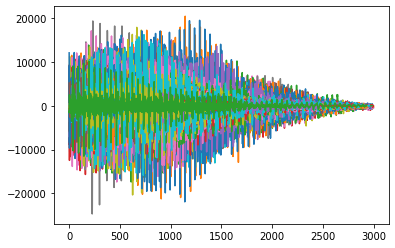

In [19]:
l = []
for i in data:
    if(len(i["audio"])<3000):
        l.append(i.get("audio"))
        plt.plot(l[-1])

In [20]:
print(len(l))

1033


In [21]:
print(dir(data))

['_GeneratorState', '__abstractmethods__', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_add_variable_with_custom_getter', '_apply_options', '_as_serialized_graph', '_checkpoint_dependencies', '_consumers', '_deferred_dependencies', '_flat_shapes', '_flat_structure', '_flat_types', '_functions', '_gather_saveables_for_checkpoint', '_graph', '_graph_attr', '_handle_deferred_dependencies', '_has_captured_ref', '_input_dataset', '_inputs', '_list_extra_dependencies_for_serialization', '_list_functions_for_serialization', '_lookup_dependency', '_map_resources', '_maybe_initialize_trackable', '_name_based_attribute_restor

In [56]:
def func(i):
    print(i)
    
    return i

data = data.map(func)

{'audio': <tf.Tensor 'args_0:0' shape=(None,) dtype=int64>, 'audio/filename': <tf.Tensor 'args_1:0' shape=() dtype=string>, 'label': <tf.Tensor 'args_2:0' shape=() dtype=int64>}


In [55]:
for i in data:
    print(i.get("audio").dtype,i.get("audio").shape,type(i.get("audio")))
    print(i["audio"].shape[0])
    tf.slice(i["audio"],[0],[1000])
    break

<dtype: 'int64'> (1525,) <class 'tensorflow.python.framework.ops.EagerTensor'>
1525


In [ ]:
print()